# Model Complexity Experiments

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

# Load the data

In [3]:
run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_064_0306_205514")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [4]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

In [5]:
ens_dir = Path("/datadrive/data/runs/complexity_AZURE")

preds = read_multi_experiment_results(ens_dir, ensemble_members=False)

Loading Ensemble Members: 8it [00:06,  1.26it/s]


In [7]:
def member_to_hs(member: str) -> int:
    return int(member.split("hs_")[1].split("_")[0])


def assign_hs_to_ds(ds: xr.Dataset) -> xr.Dataset:
    return ds.assign_coords(hs=("member", [member_to_hs(m) for m in ds.member.values]))

preds = assign_hs_to_ds(preds)
preds

<xarray.Dataset>
Dimensions:     (member: 8, station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * member      (member) <U18 'hs_256_0306_205511' ... 'hs_002_0806_095700'
    hs          (member) int64 256 64 32 128 16 8 4 2
Data variables:
    obs         (member, station_id, time) float64 2.37 2.49 2.42 ... 0.73 0.79
    sim         (member, station_id, time) float64 1.98 2.472 ... 0.7852 0.8794

In [16]:
error_path = ens_dir / "ALL_ERRORS.nc"
if error_path.exists():
    errors = xr.open_dataset(error_path)
else:
    errors = calculate_member_errors(preds, basin_coord="station_id", time_coord="time", obs_var="obs", sim_var="sim")
    errors.to_netcdf(error_path)
    
errors = assign_hs_to_ds(errors)

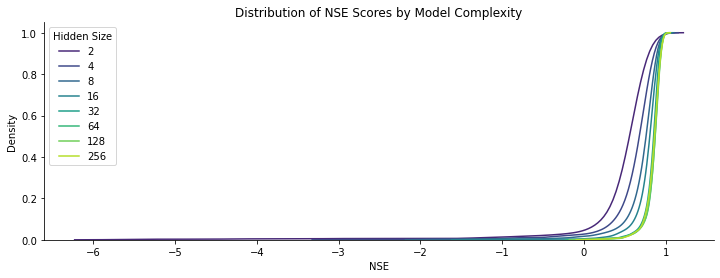

In [60]:
def is_finite(arr: np.ndarray) -> np.ndarray:
    return arr[np.isfinite(arr)]

f, ax = plt.subplots(figsize=(12, 4))
colors = sns.color_palette("viridis", 8)

cumulative = True
if cumulative:
    for ix, hs in enumerate(errors["hs"].values):
        nse = is_finite(errors["NSE"].sel(member=errors["hs"] == hs).values)
        sns.kdeplot(nse, label=hs, alpha=0.6, color=colors[ix], ax=ax, cumulative=True)
else:
    for ix, hs in enumerate(errors["hs"].values):
        nse = is_finite(errors["NSE"].sel(member=errors["hs"] == hs).values)
        ax.hist(nse, label=hs, alpha=0.6, bins=200, color=colors[ix])

plt.legend(title="Hidden Size")
ax.set_xlabel("NSE")
ax.set_title("Distribution of NSE Scores by Model Complexity")
sns.despine()

# geospatial interpretation

In [48]:
from scripts.geospatial import (initialise_gb_spatial_plot, load_latlon_points)
import geopandas as gpd

In [40]:
points = load_latlon_points(data_dir=Path("/home/tommy/spatio_temporal/data"))

In [50]:
nse_gdf = gpd.GeoDataFrame(errors["NSE"].to_dataframe().reset_index("member").drop(columns="member").join(points))

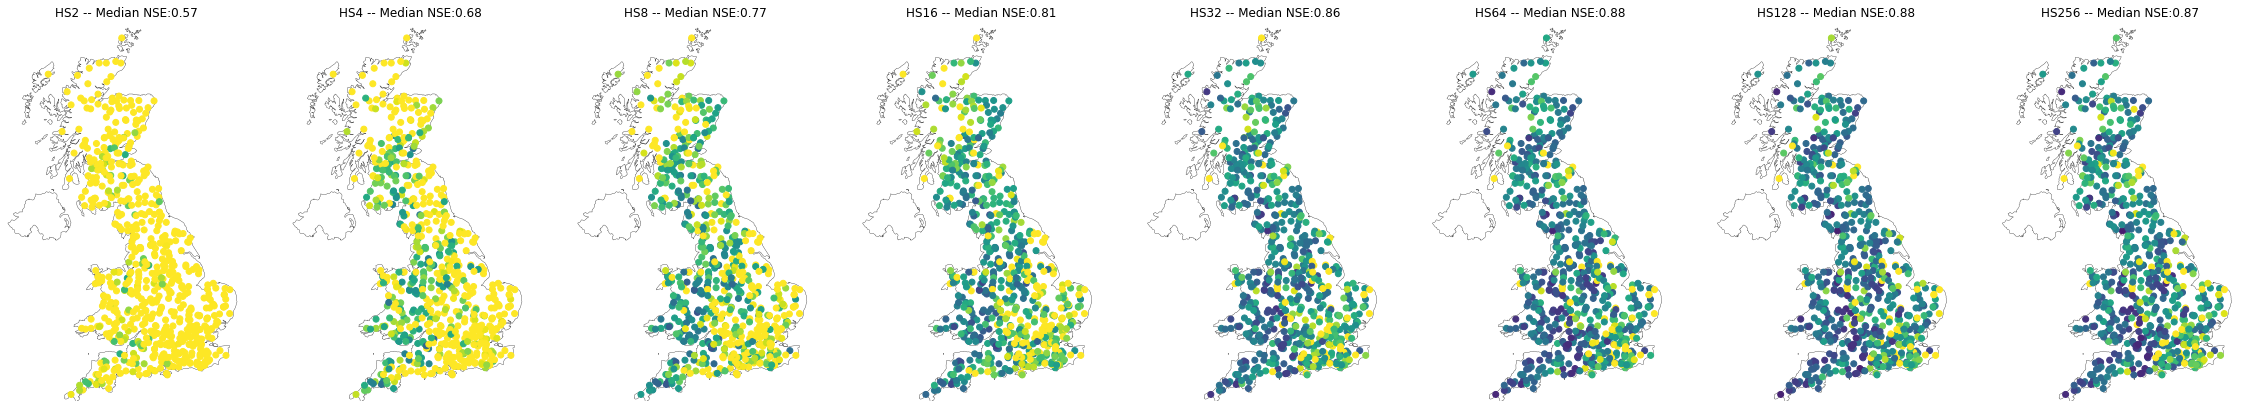

In [63]:
kwargs = {
    "vmin": 0.7, 
    "vmax": 1,
    "cmap": "viridis_r",
}

hiddens = sorted(np.unique(nse_gdf["hs"]))
f, axs = plt.subplots(1, len(hiddens), figsize=(5*len(hiddens), 8))
for ix, hs in enumerate(hiddens):
    data = nse_gdf.loc[nse_gdf["hs"] == hs]
    ax = axs[ix]
    initialise_gb_spatial_plot(ax=ax)
    data.plot("NSE", ax=ax, **kwargs)
    ax.set_title(f"HS{hs} -- Median NSE:{data['NSE'].median():.2f}")

In [46]:
from neuralhydrology.modelzoo.basemodel import BaseModel
from typing import Dict, Union, DefaultDict
from collections import defaultdict


def load_models_and_configs(experiment_dir: Path) -> DefaultDict[str, Dict[int, Union[BaseModel, Config]]]:
    model_runs = [p for p in experiment_dir.glob("*") if p.is_dir()]
    all_data = defaultdict(dict)
    
    for run_dir in model_runs:
        hs = member_to_hs(run_dir.name)
        
        # GET config
        cfg = Config(run_dir / "config.yml")
        cfg.run_dir = run_dir

        # GET model
        model = get_model(cfg).to(cfg.device)
        _load_weights(model, cfg)

        all_data["model"][hs] = model
        all_data["cfg"][hs] = cfg

    return all_data


experiment_dir = Path(f"/datadrive/data/runs/complexity_AZURE/")
all_data = load_models_and_configs(experiment_dir)

Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_256_0306_205511/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_064_0306_205514/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_032_0406_043009/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_128_0406_071636/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_016_0406_110952/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_008_0406_152419/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_004_0406_152711/model_epoch030.pt
Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_002_0806_095700/model_epoch030.pt


# Model with two hidden states

In [48]:
# SPECIFY hidden_size
HS = 2

model = all_data["model"][HS]
cfg = all_data["cfg"][HS]
run_dir = cfg.run_dir

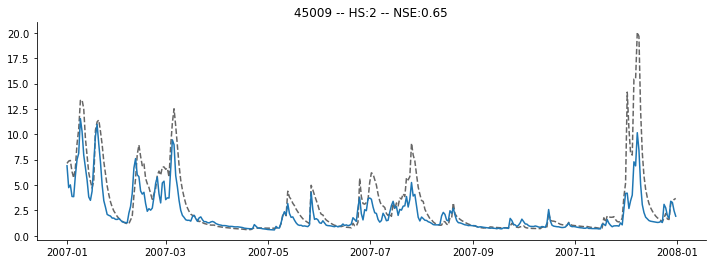

In [49]:
f, ax = plt.subplots(figsize=(12, 4))

sid = np.random.choice(preds.station_id.values)
# get space-time of interest
p = preds.sel(member=preds["hs"]==HS, station_id=sid, time="2007").squeeze()
ax.plot(p.time, p.obs, color="k", alpha=0.6, ls="--")
ax.plot(p.time, p.sim)

err = errors.sel(member=errors["hs"] == HS, station_id=sid)
ax.set_title(f"{sid} -- HS:{cfg.hidden_size} -- NSE:{float(err['NSE'].values):.2f}")
sns.despine()

# Extract cell state from model

In [50]:
from scripts.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)


if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

# visualise the model and the timeseries of each cell state

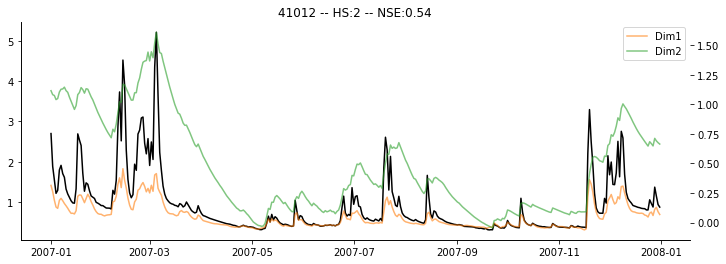

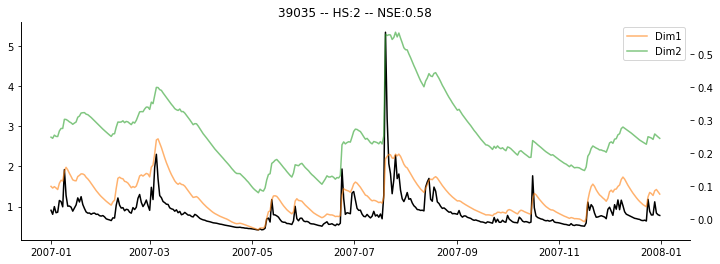

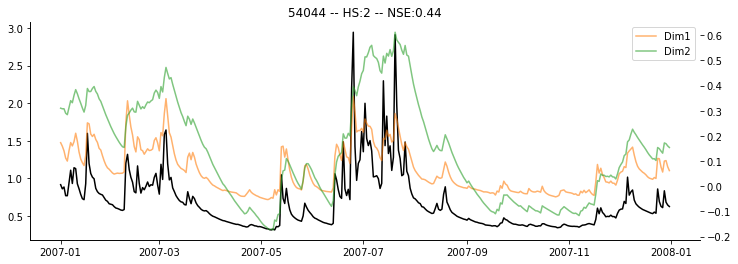

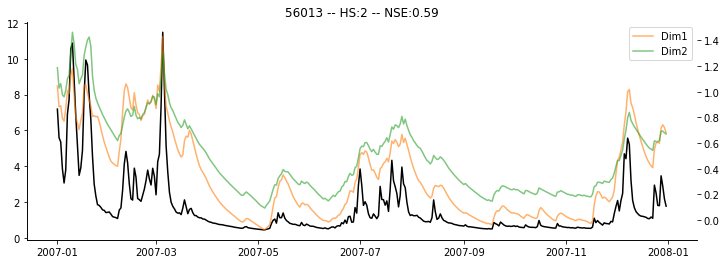

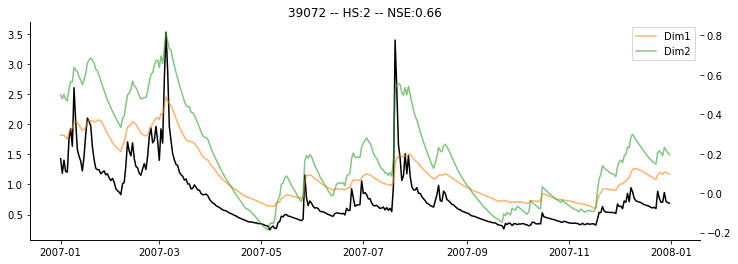

In [51]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))

    sid = np.random.choice(preds.station_id.values)
    # get space-time of interest
    p = preds.sel(member=preds["hs"]==HS, station_id=sid, time="2007").squeeze()
    c = cn.sel(station_id=str(sid), date="2007")
    
    # plot hydrograph
    # ax.plot(p.time, p.obs, color="k", alpha=0.6, ls="--", label="Obs")
    ax.plot(p.time, p.sim, label="Sim", color="k")
    
    # plot state vector values
    ax2 = ax.twinx()
    for i in cn.dimension.values:
        ax2.plot(p.time, c.c_n.isel(dimension=i), color=f"C{i+1}", label=f"Dim{i+1}", alpha=0.6)

    err = errors.sel(member=errors["hs"] == HS, station_id=sid)
    ax.set_title(f"{sid} -- HS:{cfg.hidden_size} -- NSE:{float(err['NSE'].values):.2f}")
    plt.legend()
    sns.despine()

# 4 Hidden States

In [52]:
# SPECIFY hidden_size
HS = 4

model = all_data["model"][HS]
cfg = all_data["cfg"][HS]
run_dir = cfg.run_dir

In [53]:
from scripts.extract_cell_state import get_cell_states


out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)


if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

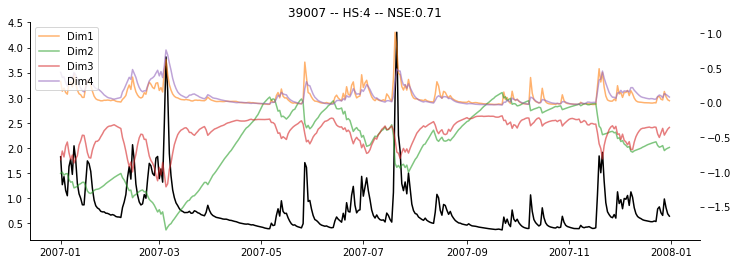

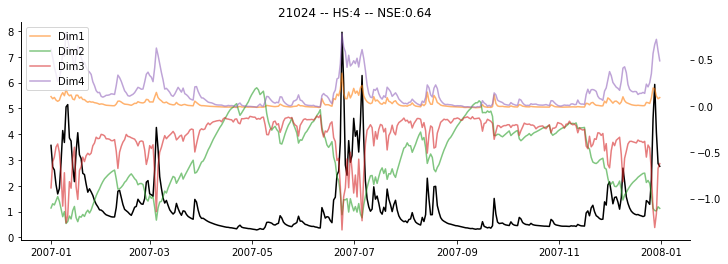

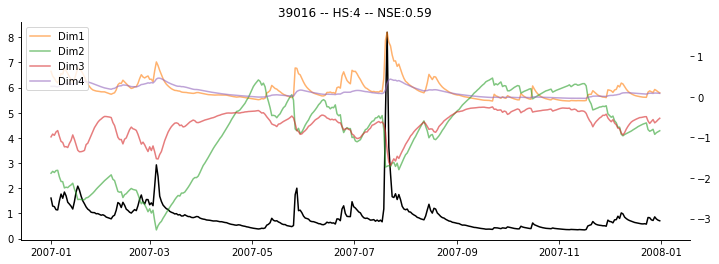

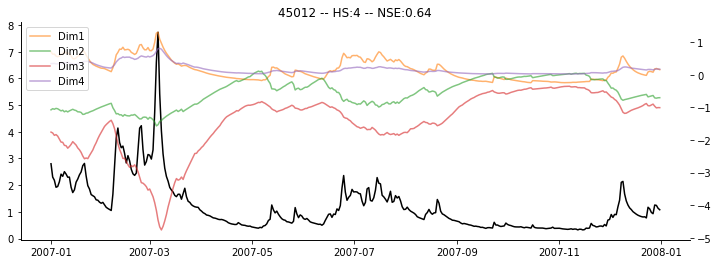

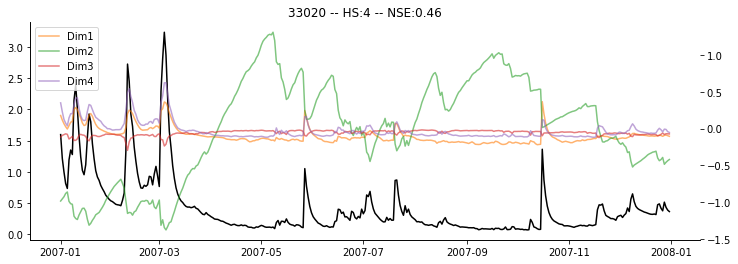

In [54]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))

    sid = np.random.choice(preds.station_id.values)
    # get space-time of interest
    p = preds.sel(member=preds["hs"]==HS, station_id=sid, time="2007").squeeze()
    c = cn.sel(station_id=str(sid), date="2007")
    
    # plot hydrograph
    # ax.plot(p.time, p.obs, color="k", alpha=0.6, ls="--", label="Obs")
    ax.plot(p.time, p.sim, label="Sim", color="k")
    
    # plot state vector values
    ax2 = ax.twinx()
    for i in cn.dimension.values:
        ax2.plot(p.time, c.c_n.isel(dimension=i), color=f"C{i+1}", label=f"Dim{i+1}", alpha=0.6)
    

    err = errors.sel(member=errors["hs"] == HS, station_id=sid)
    ax.set_title(f"{sid} -- HS:{cfg.hidden_size} -- NSE:{float(err['NSE'].values):.2f}")

    plt.legend(loc="upper left")
    sns.despine()

# PCA - how complex is the cell state 
- 64 x 64 correlation matrix of each 
- what moves together
- PCA on the 64D -> visualise the eigenvalues, gives you an idea of the complexity of the problem
- 

# Accuracy of the predictions, 
- Decoding = 
- 